Here I will try out the matrix factorisation algorythms. For this I will use the [Surprize Python package](https://surprise.readthedocs.io/). 

First I will try out the In package Movielens datasets, as per the tutorial in the package website.

In [110]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
# import os
from surprise import BaselineOnly, Dataset, Reader, SVD, NMF, accuracy, PredictionImpossible, KNNWithMeans, KNNBasic
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV, PredefinedKFold
from surprise.model_selection.split import LeaveOneOut
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from collections import defaultdict
import pandas as pd
import tempfile


In [111]:
# column_names = ['userId', 'movieId', 'rating', 'timestamp']

# data_100k = pd.read_csv('../ml-100k/u.ratings', sep="\t", names=column_names)

# reader = Reader(rating_scale=(1, 5))

# subset_test = data_100k[['userId', 'movieId', 'rating']]

# _100k_data = Dataset.load_from_df(subset_test, reader)

# print(_100k_data)

In [112]:

np.random.seed(42)

column_names = ['userId', 'movieId', 'rating', 'timestamp']

ratings = pd.read_csv('../ml-100k/u.data', sep='\t', names=column_names)

reader = Reader(rating_scale=(1, 5))

subset = ratings[['userId', 'movieId', 'rating']]
subset = subset.iloc[1:]
subset["rating"] = subset["rating"].astype(float)

custom_data = Dataset.load_from_df(subset, reader)

print(custom_data)

In [146]:
movie_data_column_names = ['movieId', 'item_title', 'release_date', 'release_date_2', "url", 
                           "IMDb URL" ,'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                           'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../ml-100k/u.item', sep='|',  encoding='ISO-8859-1', names=movie_data_column_names)
# movies = movies.iloc[:, 0:2]
# movies.columns = ['movieId', 'item_title']

# Check for duplicate 'item' IDs
duplicate_items = movies[movies.duplicated(subset='movieId', keep=False)]

# Display the duplicates
print(duplicate_items)

Empty DataFrame
Columns: [movieId, item_title, release_date, release_date_2, url, IMDb URL, Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]
Index: []

[0 rows x 24 columns]


In [114]:
# Train-test split
trainset, testset = train_test_split(custom_data, test_size=0.2)

# Train the SVD model
algo = SVD()
algo.fit(trainset)

Use SVD model to recommend movies for new users (people who have rated at least 10 movies) and based on that, predict what other movies they would likely enjoy. 

First I will do a dummy run through as a proof of concept

In [115]:


# Predict for a new user
# Suppose you have userId = 12345 who rated 10 movies
# Now predict ratings for movies they have NOT rated
all_movie_ids = ratings['movieId'].unique()
rated_movies = ratings[ratings['userId'] == 12345]['movieId'].tolist()
print(f"User: {rated_movies}")
print(f"User movies: {rated_movies}")

movies_to_predict = [movie for movie in all_movie_ids if movie not in rated_movies]

# Make predictions
predictions = []
for movie_id in movies_to_predict:
    pred = algo.predict(12345, movie_id)
    predictions.append((movie_id, pred.est))

# Sort predictions by estimated rating
predictions.sort(key=lambda x: x[1], reverse=True)

# Recommend top 10 movies
top_10 = predictions[:10]

for index, (integer_value, float_value) in enumerate(top_10):
    movie_title = movies.loc[integer_value, 'item_title']
    print(f"Position: {index}, Movie: {movie_title}, Predicted rating: {float_value}")
    

User: []
User movies: []
Position: 0, Movie: Cinema Paradiso (1988), Predicted rating: 4.581708391298929
Position: 1, Movie: Everyone Says I Love You (1996), Predicted rating: 4.580530269390127
Position: 2, Movie: What's Eating Gilbert Grape (1993), Predicted rating: 4.573436263451
Position: 3, Movie: Maltese Falcon, The (1941), Predicted rating: 4.552318344422202
Position: 4, Movie: Jack (1996), Predicted rating: 4.528909891186977
Position: 5, Movie: Annie Hall (1977), Predicted rating: 4.455029958631393
Position: 6, Movie: Mighty Aphrodite (1995), Predicted rating: 4.44071242515515
Position: 7, Movie: Haunted World of Edward D. Wood Jr., The (1995), Predicted rating: 4.417475584056654
Position: 8, Movie: It Happened One Night (1934), Predicted rating: 4.412549289235366
Position: 9, Movie: Apartment, The (1960), Predicted rating: 4.406388337899761


Next, I will try with a known user, with at least 20 ratings. I will use userId 42, who has more than 20 ratings in the dataset. I will randomly select 10 of those ratings to simulate the "user with 10 ratings" situation. Then, I will use the SVD model to predict ratings for the remaining movies that the user has not yet rated. Next, I will recommend the top 10 movies based on the predicted ratings. Since we already know the users full ratings, we can the test our predictions against the he actual ratings. This will give us an idea of how accurate our recommendations are. 

###RMSE (Root Mean Squared Error):
•	RMSE measures how close the predicted ratings are to the real ratings.
•	It's a "regression" metric.
•	Example:
o	True rating = 4.0
o	Predicted rating = 3.5
o	Error = 0.5
•	RMSE gives you the "average size of the errors" across many predictions.
•	Lower RMSE is better (closer to real ratings).


In [116]:
# Simulate the "user with 10 ratings" situation
userId = 42
user_ratings = ratings[ratings['userId'] == userId]

print(f"User {userId} has rated {len(user_ratings)} movies.")
# Only if the user has enough ratings
if len(user_ratings) >= 20:
    # Randomly select 10 known ratings from simualted user
    known_ratings = user_ratings.sample(10)
    known_movies = known_ratings['movieId'].tolist()
    print(f"Known Movies: {known_movies}")
    
    # The rest are the hidden "test" ratings
    hidden_ratings = user_ratings[~user_ratings['movieId'].isin(known_movies)]
    hidden_ratings = hidden_ratings.sort_values(by="rating")
    print(f"Hidden Movies: {hidden_ratings}")

    # Now, imagine training the model ONLY with the 10 ratings for this user.
    # Since we can't re-train, we simulate by making predictions anyway.
    
    # Make predictions for the hidden movies
    testset_user = [
        (userId, movie_id, true_rating) for movie_id, true_rating in zip(
            hidden_ratings['movieId'], 
            hidden_ratings['rating']
            )]
    print(f"testset user {testset_user}")
    predictions = algo.test(testset_user)

    # Calculate RMSE or other metrics
    rmse = accuracy.rmse(predictions)
    print(f"RMSE for user {userId} with only 10 ratings: {rmse}")


User 42 has rated 183 movies.
Known Movies: [1045, 142, 97, 655, 234, 939, 720, 443, 685, 521]
Hidden Movies:        userId  movieId  rating  timestamp
19661      42      276       1  881105405
18428      42      413       1  881106072
70653      42     1048       1  881106220
73843      42      111       1  881105931
70257      42      595       1  881106582
...       ...      ...     ...        ...
15383      42      215       5  881107413
15339      42      496       5  881107718
15338      42      194       5  881107329
20548      42        1       5  881105633
18663      42       77       5  881108684

[173 rows x 4 columns]
testset user [(42, 276, 1), (42, 413, 1), (42, 1048, 1), (42, 111, 1), (42, 595, 1), (42, 219, 1), (42, 834, 1), (42, 1043, 2), (42, 679, 2), (42, 559, 2), (42, 43, 2), (42, 131, 2), (42, 451, 2), (42, 627, 2), (42, 433, 2), (42, 658, 2), (42, 367, 2), (42, 462, 2), (42, 977, 2), (42, 953, 2), (42, 175, 2), (42, 103, 3), (42, 428, 3), (42, 826, 3), (42, 409, 3

I have just performed a test on one user out of the dataset where the user has only predicted 10 movies. The RMSE for this user is 0.7659. This means that the model's predictions are, on average, 0.7659 units away from the actual ratings. This is a relatively high error, which suggests that the model may not be very accurate for this user. However, it's important to note that this is just one user and the model may perform better for other users.

Next, we will perform the same prediction test with a larger sample of users. 

In [117]:
# Find users with at least 20 ratings
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index.tolist()

print(f"Eligible users {len(eligible_users)}")

# We'll sample (say) 100 users to test
sampled_users = random.sample(eligible_users, 100)

user_rmse_scores = []

for userId in sampled_users:
    user_ratings = ratings[ratings['userId'] == userId]

    # Select 10 known ratings
    known_ratings = user_ratings.sample(10, random_state=42)
    known_movies = known_ratings['movieId'].tolist()
    
    # Hidden ratings
    hidden_ratings = user_ratings[~user_ratings['movieId'].isin(known_movies)]
    
    if hidden_ratings.empty:
        continue  # Skip if no hidden ratings (shouldn't happen but just in case)

    # Create a testset for this user: predict for hidden movies
    testset_user = [(userId, movieId, true_rating) for movieId, true_rating in zip(hidden_ratings['movieId'], hidden_ratings['rating'])]

    predictions = algo.test(testset_user)
    
    # Calculate RMSE for this user
    rmse = accuracy.rmse(predictions, verbose=False)
    user_rmse_scores.append(rmse)

# Now calculate overall average RMSE
average_rmse = np.mean(user_rmse_scores)
print(f"Average RMSE across {len(user_rmse_scores)} users with only 10 ratings: {average_rmse}")


Eligible users 943
Average RMSE across 100 users with only 10 ratings: 0.7339249911396977


The RMSE across 100 users is with only 10 ratings is 0.7341. The error has decreased ed slightly compared to the previous test with a single user. This suggests that the model is more accurate when predicting for a larger sample of users. However, it's important to note that this is still a relatively high error, which suggests that the model may not be very accurate for users with only a few ratings.

Next, we can test if the RMSE goes down to a lower value when we increase the number of ratings to 20. I will also test with other amounts of ratings to see if there is a pattern.

In [118]:
# Find users with at least 50 ratings
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 50].index.tolist()

# Sample 100 users
sampled_users = random.sample(eligible_users, 100)

# Different number of known ratings to test
known_ratings_list = [5, 10, 20, 30, 40]

rmse_results = []

for num_known in known_ratings_list:
    user_rmse_scores = []
    
    for userId in sampled_users:
        user_ratings = ratings[ratings['userId'] == userId]
        
        if len(user_ratings) < num_known + 5:  # Make sure there's enough hidden ratings
            continue
        
        known_ratings = user_ratings.sample(num_known, random_state=42)
        known_movies = known_ratings['movieId'].tolist()
        
        hidden_ratings = user_ratings[~user_ratings['movieId'].isin(known_movies)]
        
        if hidden_ratings.empty:
            continue

        testset_user = [(userId, movie_id, true_rating) for movie_id, true_rating in zip(hidden_ratings['movieId'], hidden_ratings['rating'])]

        predictions = algo.test(testset_user)
        
        rmse = accuracy.rmse(predictions, verbose=False)
        user_rmse_scores.append(rmse)
    
    # Average RMSE for this number of known ratings
    avg_rmse = np.mean(user_rmse_scores)
    rmse_results.append(avg_rmse)
    print(f"Known ratings: {num_known} -> Average RMSE: {avg_rmse:.4f}")




Known ratings: 5 -> Average RMSE: 0.7344
Known ratings: 10 -> Average RMSE: 0.7346
Known ratings: 20 -> Average RMSE: 0.7328
Known ratings: 30 -> Average RMSE: 0.7320
Known ratings: 40 -> Average RMSE: 0.7310


Plot the above findings 

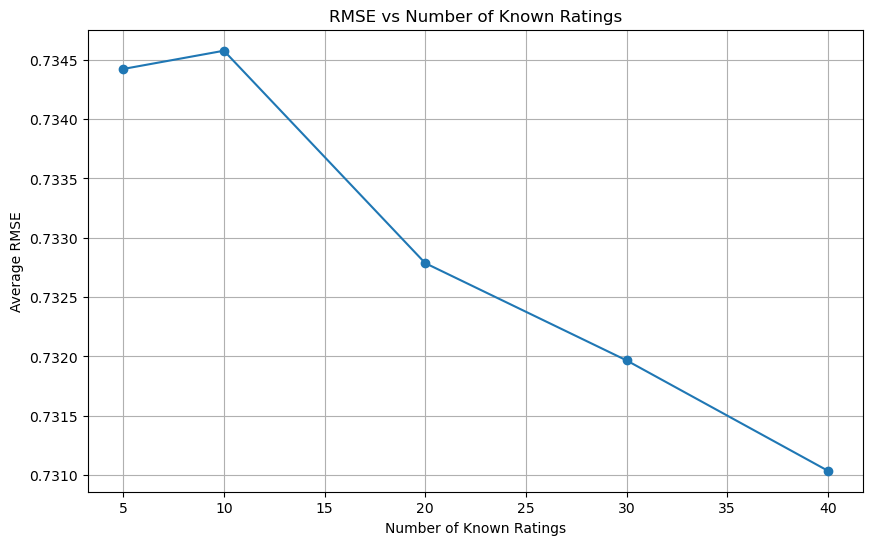

In [119]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(known_ratings_list, rmse_results, marker='o')
plt.title('RMSE vs Number of Known Ratings')
plt.xlabel('Number of Known Ratings')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.show()

this is a very interesting chart, as it shows that error does not go down that much, even when the user has rated as many as 40 movies, when compared to a user who has only rated 5 movies 

Next I will create a svd recommender that tests the models precision@k rather than RMSE

In [120]:
# Get all users
all_users = ratings['userId'].unique()

# Sample 100 users who have rated a lot
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index.tolist()
sampled_users = random.sample(eligible_users, 100)

k = 10  # Top 10 recommendations

precision_scores = []

for user_id in sampled_users:
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Simulate that we only know a few ratings
    known_ratings = user_ratings.sample(10, random_state=42)
    known_movies = set(known_ratings['movieId'])
    
    # Candidate movies: everything except what user has already rated
    all_movies = set(ratings['movieId'].unique())
    unseen_movies = list(all_movies - known_movies)
    
    # Predict ratings for unseen movies
    predictions = [ (movie_id, algo.predict(user_id, movie_id).est) for movie_id in unseen_movies ]
    
    # Sort movies by predicted rating, highest first
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Take top-k movies
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    
    # What are the movies the user *actually liked* (rated 4.0 or higher)?
    true_liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
    
    if not true_liked_movies:
        continue  # Skip user if they have no strong likes

    # Calculate Precision@K
    relevant_in_top_k = sum([1 for movie_id in top_k_movies if movie_id in true_liked_movies])
    precision_at_k = relevant_in_top_k / k
    precision_scores.append(precision_at_k)

# Final Precision@K
average_precision = np.mean(precision_scores)
print(f"Average Precision@{k}: {average_precision:.4f}")


Average Precision@10: 0.3030


next we will calculate the following metrics: Precision@k, Recall@K, NDCG@K

In [121]:
# Get all users
all_users = ratings['userId'].unique()

# Sample 100 users who have rated enough
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index.tolist()
sampled_users = random.sample(eligible_users, 100)

k = 10  # Top 10 recommendations

precision_scores = []
recall_scores = []
ndcg_scores = []

for user_id in sampled_users:
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Simulate 10 known ratings
    known_ratings = user_ratings.sample(10, random_state=42)
    known_movies = set(known_ratings['movieId'])
    
    # Candidate movies: unseen
    all_movies = set(ratings['movieId'].unique())
    unseen_movies = list(all_movies - known_movies)
    
    # Predict ratings for unseen movies
    predictions = [ (movie_id, algo.predict(user_id, movie_id).est) for movie_id in unseen_movies ]
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Top-K recommended movies
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    
    # Movies the user actually liked (rating >= 4)
    true_liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
    
    if not true_liked_movies:
        continue  # Skip user if no strong likes
    
    # --- Calculate Precision@K ---
    relevant_in_top_k = sum([1 for movie_id in top_k_movies if movie_id in true_liked_movies])
    precision_at_k = relevant_in_top_k / k
    precision_scores.append(precision_at_k)
    
    # --- Calculate Recall@K ---
    recall_at_k = relevant_in_top_k / len(true_liked_movies)
    recall_scores.append(recall_at_k)
    
    # --- Calculate NDCG@K ---
    dcg = 0.0
    for idx, movie_id in enumerate(top_k_movies):
        if movie_id in true_liked_movies:
            dcg += 1.0 / np.log2(idx + 2)  # +2 because index starts from 0
    
    # Ideal DCG (IDCG)
    ideal_relevant = min(len(true_liked_movies), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_relevant))
    
    ndcg = dcg / idcg if idcg > 0 else 0.0
    ndcg_scores.append(ndcg)

# Final results
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_ndcg = np.mean(ndcg_scores)

print(f"Average Precision@{k}: {average_precision:.4f}")
print(f"Average Recall@{k}: {average_recall:.4f}")
print(f"Average NDCG@{k}: {average_ndcg:.4f}")


Average Precision@10: 0.3260
Average Recall@10: 0.0503
Average NDCG@10: 0.3396


 
1. Precision@K (quick reminder)
Imagine you recommend 5 movies (K=5).
Out of those, the user actually likes 3 movies.
•	Precision@5 = (3 liked) / (5 recommended) = 0.6
It measures:
"Out of what I recommended, how much was good?"
 
2. Recall@K
Now imagine the user loves 10 movies in total (out of the full catalog), but you only recommended 5 movies.
You recommended 3 of those 10 favorite movies.
•	Recall@5 = (3 liked) / (10 possible liked) = 0.3
So recall measures:
"Out of all the things the user could have liked, how many did I show them?"
In simple words:
•	Precision asks: "Was what I recommended good?"
•	Recall asks: "Did I miss anything the user would have liked?"
 
3. NDCG@K (Normalized Discounted Cumulative Gain)
This is a little fancier, but extremely important for ranking.
NDCG@K measures:
•	Not just what you recommended,
•	but whether you ranked the best stuff at the top.
Because in real apps (Netflix, Amazon, Spotify...),
users only see the first few recommendations.
If you recommend their favorite movie at position #1, that's awesome.
If it's hidden at position #10, that's worse.
NDCG gives bonus points for ranking good movies higher.


Now that we have established some new metrics, we will plot the differences in metrics acorss different initial ratings

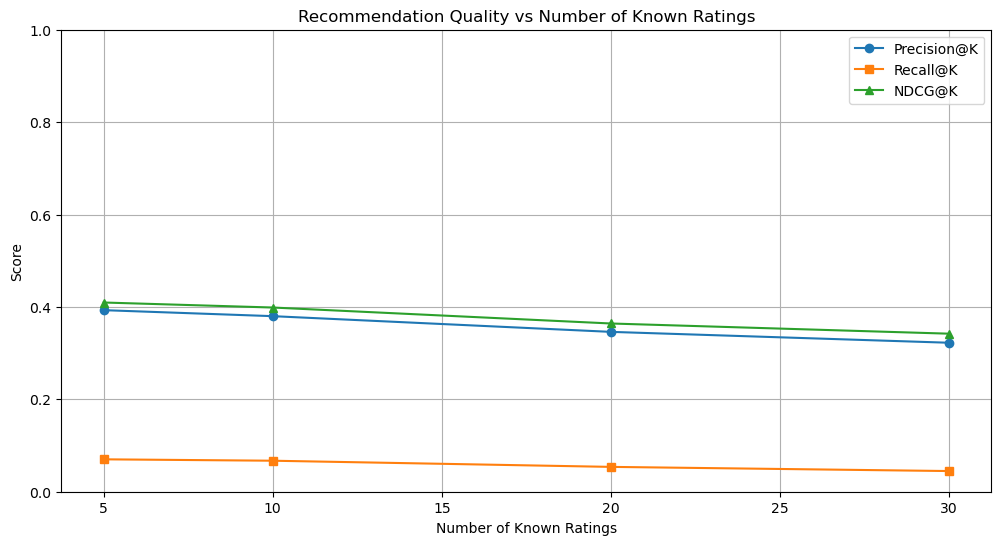

In [122]:
# Get all users
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 30].index.tolist()
sampled_users = random.sample(eligible_users, 100)  # Pick users with at least 30 ratings

k = 10  # Top 10 recommendations

# Different numbers of known ratings to test
known_ratings_list = [5, 10, 20, 30]

# To store results
precision_at_k_all = []
recall_at_k_all = []
ndcg_at_k_all = []

for known_ratings_size in known_ratings_list:
    precision_scores = []
    recall_scores = []
    ndcg_scores = []
    
    for user_id in sampled_users:
        user_ratings = ratings[ratings['userId'] == user_id]
        
        if len(user_ratings) < known_ratings_size + 1:
            continue  # Skip if not enough ratings
        
        known_ratings = user_ratings.sample(known_ratings_size, random_state=42)
        known_movies = set(known_ratings['movieId'])
        
        all_movies = set(ratings['movieId'].unique())
        unseen_movies = list(all_movies - known_movies)
        
        predictions = [ (movie_id, algo.predict(user_id, movie_id).est) for movie_id in unseen_movies ]
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
        
        true_liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
        
        if not true_liked_movies:
            continue
        
        relevant_in_top_k = sum([1 for movie_id in top_k_movies if movie_id in true_liked_movies])
        
        # Precision@K
        precision_at_k = relevant_in_top_k / k
        precision_scores.append(precision_at_k)
        
        # Recall@K
        recall_at_k = relevant_in_top_k / len(true_liked_movies)
        recall_scores.append(recall_at_k)
        
        # NDCG@K
        dcg = 0.0
        for idx, movie_id in enumerate(top_k_movies):
            if movie_id in true_liked_movies:
                dcg += 1.0 / np.log2(idx + 2)
        
        ideal_relevant = min(len(true_liked_movies), k)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_relevant))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)
    
    # Average over users
    precision_at_k_all.append(np.mean(precision_scores))
    recall_at_k_all.append(np.mean(recall_scores))
    ndcg_at_k_all.append(np.mean(ndcg_scores))

# --- Now, plot everything ---

plt.figure(figsize=(12, 6))

plt.plot(known_ratings_list, precision_at_k_all, marker='o', label='Precision@K')
plt.plot(known_ratings_list, recall_at_k_all, marker='s', label='Recall@K')
plt.plot(known_ratings_list, ndcg_at_k_all, marker='^', label='NDCG@K')

plt.title('Recommendation Quality vs Number of Known Ratings')
plt.xlabel('Number of Known Ratings')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


We can see that acorss all metrics, that more ratings do not give much better results.  

Next, I will perform a cold-start train/test a larger amount of data. This will use a 80/20 train-test split, but the prediction data will need to be refined to simualte cold start problem. 

We’ll simulate cold-start within a normal 80/20 split by:
1.	Doing a standard 80/20 split of ratings.
2.	From the test set, identify users who appear in both train and test.
3.	For each such user:
    - Keep only 5 ratings in training.
    - Keep the rest of their ratings in the test set.
This ensures we simulate a user who has just 5 known ratings at prediction time.


In [123]:
# Convert trainset to DataFrame
train_df = pd.DataFrame(trainset.build_testset(), columns=['user', 'item', 'rating'])
test_df = pd.DataFrame(testset, columns=['user', 'item', 'rating'])

# Identify shared users
shared_users = set(train_df['user']) & set(test_df['user'])

# Keep only 5 ratings per shared user in the train set
limited_train_rows = []
for user in shared_users:
    user_ratings = train_df[train_df['user'] == user]
    if len(user_ratings) > 5:
        sampled = user_ratings.sample(5, random_state=42)
    else:
        sampled = user_ratings
    limited_train_rows.append(sampled)

# Add all non-shared users back
non_shared_users_df = train_df[~train_df['user'].isin(shared_users)]
cold_start_train_df = pd.concat(limited_train_rows + [non_shared_users_df])

# Build the final trainset
cold_start_data = Dataset.load_from_df(cold_start_train_df[['user', 'item', 'rating']], reader)
cold_start_trainset = cold_start_data.build_full_trainset()

# Define a custom SVD to raise errors on unknowns (optional)
class ColdStartSVD(SVD):
    def estimate(self, u, i):
        if not self.trainset.knows_user(u) or not self.trainset.knows_item(i):
            raise PredictionImpossible("Cold start issue: user or item not in training set.")
        return super().estimate(u, i)

# Train the model
algo = ColdStartSVD()
algo.fit(cold_start_trainset)

# Test and evaluate
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

print(f"RMSE on cold-start users: {rmse}")


RMSE: 1.0695
RMSE on cold-start users: 1.069456686896876


Now i will remove all uesers who have less than 5 ratings in the Test set

In [124]:
# Convert to DataFrames for manipulation
train_df = pd.DataFrame(trainset.build_testset(), columns=['user', 'item', 'rating'])
test_df = pd.DataFrame(testset, columns=['user', 'item', 'rating'])

# Step 1: Filter users with >= 5 test ratings
test_user_counts = test_df['user'].value_counts()
eligible_test_users = test_user_counts[test_user_counts >= 5].index

# Step 2: Keep only eligible users in test set
filtered_test_df = test_df[test_df['user'].isin(eligible_test_users)]

# Step 3: Reduce training data to 5 ratings per user for these test users (simulate cold start)
limited_train_rows = []
for user in eligible_test_users:
    user_ratings = train_df[train_df['user'] == user]
    if len(user_ratings) > 5:
        sampled = user_ratings.sample(5, random_state=42)
    else:
        sampled = user_ratings
    limited_train_rows.append(sampled)

# Step 4: Add all training data from non-eligible users (normal users)
non_eligible_users_df = train_df[~train_df['user'].isin(eligible_test_users)]
cold_start_train_df = pd.concat(limited_train_rows + [non_eligible_users_df], ignore_index=True)

# Build training set for Surprise
cold_start_data = Dataset.load_from_df(cold_start_train_df[['user', 'item', 'rating']], reader)
cold_start_trainset = cold_start_data.build_full_trainset()

# Custom SVD to raise prediction errors when needed (optional)
class ColdStartSVD(SVD):
    def estimate(self, u, i):
        if not self.trainset.knows_user(u) or not self.trainset.knows_item(i):
            raise PredictionImpossible("Cold start issue: user or item not in training set.")
        return super().estimate(u, i)

# Train the model
algo = ColdStartSVD()
algo.fit(cold_start_trainset)

# Build the final test set for Surprise
final_testset = [tuple(x) for x in filtered_test_df.to_numpy()]
predictions = algo.test(final_testset)

# Evaluate
rmse = accuracy.rmse(predictions)
print(f"RMSE on filtered cold-start test users (with 5 training ratings each): {rmse}")


RMSE: 1.0661
RMSE on filtered cold-start test users (with 5 training ratings each): 1.0661260077459283


Rmse is slightly better.

Lets look at another model - KNN. How does this do at cold start problem

In [125]:
# Get all users from trainset and testset
train_users = []
for u in trainset.all_users():
    raw_uid = trainset.to_raw_uid(u)
    train_users.append(raw_uid)

test_users = []
for uid, _, _ in testset:
    test_users.append(uid)

# Find users that are in both sets
shared_users = set(train_users).intersection(set(test_users))


# Group test ratings by user
test_ratings_by_user = defaultdict(list)
for uid, iid, rating in testset:
    if uid in shared_users:
        test_ratings_by_user[uid].append((uid, iid, rating))

# Build cold-start train/test sets: use 5 ratings for train, the rest for test
cold_start_trainset = []
cold_start_testset = []

for uid in shared_users:
    user_ratings = test_ratings_by_user[uid]
    if len(user_ratings) >= 6:
        np.random.shuffle(user_ratings)
        cold_start_trainset.extend(user_ratings[:5])
        cold_start_testset.extend(user_ratings[5:])

# Create Surprise trainset from cold-start training ratings
reader = Reader(line_format='user item rating', rating_scale=(1, 5))
cold_start_data = Dataset.load_from_df(pd.DataFrame(cold_start_trainset, columns=['userID', 'itemID', 'rating']), reader)
cold_trainset = cold_start_data.build_full_trainset()

# Configure and train KNNWithMeans (item-based)
sim_options = {'name': 'pearson_baseline', 'user_based': False}
model = KNNWithMeans(sim_options=sim_options)
model.fit(cold_trainset)

# Make predictions on cold-start test set
predictions = model.test(cold_start_testset)

# Evaluate performance
rmse = accuracy.rmse(predictions)
print(f"Cold-start RMSE (item-based KNNWithMeans): {rmse:.4f}")


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.1603
Cold-start RMSE (item-based KNNWithMeans): 1.1603


In [126]:
# Convert to DataFrames for manipulation
train_df = pd.DataFrame(trainset.build_testset(), columns=['user', 'item', 'rating'])
test_df = pd.DataFrame(testset, columns=['user', 'item', 'rating'])

# Step 1: Filter users with >= 5 test ratings
test_user_counts = test_df['user'].value_counts()
eligible_test_users = test_user_counts[test_user_counts >= 5].index

# Step 2: Keep only eligible users in test set
filtered_test_df = test_df[test_df['user'].isin(eligible_test_users)]

# Step 3: Reduce training data to 5 ratings per user for these test users (simulate cold start)
limited_train_rows = []
for user in eligible_test_users:
    user_ratings = train_df[train_df['user'] == user]
    if len(user_ratings) > 5:
        sampled = user_ratings.sample(5, random_state=42)
    else:
        sampled = user_ratings
    limited_train_rows.append(sampled)

# Step 4: Add all training data from non-eligible users (normal users)
non_eligible_users_df = train_df[~train_df['user'].isin(eligible_test_users)]
cold_start_train_df = pd.concat(limited_train_rows + [non_eligible_users_df], ignore_index=True)

# Build training set for Surprise
cold_start_data = Dataset.load_from_df(cold_start_train_df[['user', 'item', 'rating']], reader)
cold_start_trainset = cold_start_data.build_full_trainset()

# Train KNNWithMeans model (item-based filtering)
sim_options = {
    'name': 'pearson_baseline',  # or 'cosine', 'pearson'
    'user_based': False          # set to False for item-based
}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(cold_start_trainset)

# Build the final test set for Surprise
final_testset = [tuple(x) for x in filtered_test_df.to_numpy()]
predictions = algo.test(final_testset)

# Evaluate
rmse = accuracy.rmse(predictions)
print(f"RMSE on filtered cold-start test users (KNNWithMeans, 5 training ratings each): {rmse}")


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.1657
RMSE on filtered cold-start test users (KNNWithMeans, 5 training ratings each): 1.1656799090191148


Next i will try out the gridsearch feature on surprise library

In [127]:
# # Select test users with at least 5 ratings
# test_counts = test_df['user'].value_counts()
# eligible_users = test_counts[test_counts >= 5].index

# # Limit each eligible user's train ratings to 5
# limited_train = []
# for user in eligible_users:
#     user_rows = train_df[train_df['user'] == user]
#     sampled = user_rows.sample(min(5, len(user_rows)), random_state=42)
#     limited_train.append(sampled)

# # Add the rest of training data (from non-cold-start users)
# non_eligible_train = train_df[~train_df['user'].isin(eligible_users)]
# cold_start_train = pd.concat(limited_train + [non_eligible_train])

# # Filter test data to only those eligible cold start users
# cold_start_test = test_df[test_df['user'].isin(eligible_users)]

# # Save as temporary files for Surprise to read
# train_file = tempfile.NamedTemporaryFile(mode='w+', delete=False)
# test_file = tempfile.NamedTemporaryFile(mode='w+', delete=False)
# cold_start_train.to_csv(train_file.name, index=False, header=False)
# cold_start_test.to_csv(test_file.name, index=False, header=False)

# # Create dataset for PredefinedKFold
# reader = Reader(rating_scale=(1, 5))
# folds = [(train_file.name, test_file.name)]
# data = Dataset.load_from_folds(folds, reader)
# pkf = PredefinedKFold()

# # Grid search config
# param_grid = {
#     'n_epochs': [10, 20],
#     'lr_all': [0.002, 0.005],
#     'reg_all': [0.02, 0.1]
# }

# # Run grid search
# gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=pkf)
# gs.fit(data)

# # Output the best result
# print("Best RMSE:", gs.best_score['rmse'])
# print("Best parameters:", gs.best_params['rmse'])



In [128]:
# Grid search config
param_grid = {
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

# Run grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(custom_data)

# Output the best result
print("Best RMSE:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])


Best RMSE: 0.9351875866316665
Best parameters: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


In [129]:
# Grid search config
param_grid = {
    'n_epochs': [10, 20],
    'lr_bu': [0.002],
    'lr_bi': [0.002],
    'lr_pu': [0.005],
    'lr_qi': [0.005],
    'reg_bu': [0.02],
    'reg_bi': [0.02],
    'reg_pu': [0.1],
    'reg_qi': [0.1]
}


# Run grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(custom_data)

# Output the best result
print("Best RMSE:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

Best RMSE: 0.9404997289932517
Best parameters: {'n_epochs': 20, 'lr_bu': 0.002, 'lr_bi': 0.002, 'lr_pu': 0.005, 'lr_qi': 0.005, 'reg_bu': 0.02, 'reg_bi': 0.02, 'reg_pu': 0.1, 'reg_qi': 0.1}


first hybrid system

In [130]:
# raw_df = pd.DataFrame(data.raw_ratings, columns=['user', 'item', 'rating', 'timestamp'])

# Create utility matrix: rows = items, columns = users
pivot = ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

# Compute item similarity and cluster items
item_vectors = pivot.values
k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
item_clusters = kmeans.fit_predict(item_vectors)

# Map item ID to cluster
item_to_cluster = dict(zip(pivot.index, item_clusters))

# Add cluster info to dataframe
ratings['cluster'] = ratings['movieId'].map(item_to_cluster)

# Split dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Convert trainset to DataFrame
train_df = pd.DataFrame(trainset.build_testset(), columns=['userId', 'movieId', 'rating'])
train_df['cluster'] = train_df['movieId'].map(item_to_cluster)

# Train one SVD model per cluster
cluster_models = {}
for cluster_id in range(k):
    cluster_data = train_df[train_df['cluster'] == cluster_id]
    if cluster_data.empty:
        continue
    cluster_dataset = Dataset.load_from_df(cluster_data[['userId', 'movieId', 'rating']], reader)
    cluster_trainset = cluster_dataset.build_full_trainset()
    model = SVD()
    model.fit(cluster_trainset)
    cluster_models[cluster_id] = (model, cluster_trainset)

# Predict using the appropriate model for each item's cluster
predictions = []
for uid, iid, true_r in testset:
    cluster_id = item_to_cluster.get(iid)
    model_info = cluster_models.get(cluster_id)
    
    if model_info is not None:
        model, cluster_trainset = model_info
        try:
            # Convert raw IDs to inner IDs for training set
            uid_inner = cluster_trainset.to_inner_uid(uid) if cluster_trainset.knows_user(uid) else None
            iid_inner = cluster_trainset.to_inner_iid(iid) if cluster_trainset.knows_item(iid) else None

            if uid_inner is not None and iid_inner is not None:
                pred = model.predict(uid, iid, r_ui=true_r)
            else:
                pred = None
        except:
            pred = None
    else:
        pred = None

    if pred is not None:
        predictions.append(pred)

# Evaluate
if predictions:
    rmse = accuracy.rmse(predictions)
    print(f"Hybrid RMSE: {rmse}")
else:
    print("No predictions were made.")


RMSE: 1.0011
Hybrid RMSE: 1.001058230789922


Total comparison

Baseline (Bias) Models

In [131]:
# Train the baseline (global mean + biases)
algo = BaselineOnly()    
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE for rating prediction
rmse = accuracy.rmse(predictions, verbose=False)
print(f'BaselineOnly RMSE: {rmse:.4f}')


Estimating biases using als...
BaselineOnly RMSE: 0.9442


Memory-based Collaborative Filtering (KNN)

In [132]:
# User-based KNN with k=30 neighbors
sim_options = {'name': 'pearson_baseline', 'user_based': True}
knn_user = KNNBasic(k=30, sim_options=sim_options)
knn_user.fit(trainset)
predictions_knn = knn_user.test(testset)
print(f'KNNBasic (user) RMSE: {accuracy.rmse(predictions_knn, verbose=False):.4f}')


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
KNNBasic (user) RMSE: 1.0011


Model-based (Latent Factor) Models: SVD and NMF

In [133]:
# Train SVD (Funk SVD) on full training set
svd = SVD(n_factors=50, n_epochs=20, random_state=42)
svd.fit(trainset)
predictions_svd = svd.test(testset)
print(f'SVD RMSE: {accuracy.rmse(predictions_svd, verbose=False):.4f}')



SVD RMSE: 0.9348


In [134]:

# Train NMF on the same data
nmf = NMF(n_factors=15, n_epochs=50, random_state=42)
nmf.fit(trainset)
predictions_nmf = nmf.test(testset)
print(f'NMF RMSE: {accuracy.rmse(predictions_nmf, verbose=False):.4f}')

NMF RMSE: 0.9594


compute Precision@K and Recall@K for predictions

In [135]:

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = []
    recalls = []
    for uid, rated in user_est_true.items():
        rated.sort(key=lambda x: x[0], reverse=True)
        top_k = rated[:k]
        n_relevant = sum((true >= threshold) for (_, true) in rated)
        n_recommended = sum((true >= threshold) for (_, true) in top_k)
        precisions.append(n_recommended / k if k else 0)
        recalls.append(n_recommended / n_relevant if n_relevant else 0)
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls)

# Compute for SVD predictions as an example
p10, r10 = precision_recall_at_k(predictions_svd, k=10)
print(f'SVD Precision@10: {p10:.3f}, Recall@10: {r10:.3f}')


SVD Precision@10: 0.582, Recall@10: 0.721


Hybrid Approaches: Clustering + Latent Factors


In [136]:


ratings = pd.read_csv('../ml-100k/u.data', sep='\t', 
                          names=['user', 'item', 'rating', 'timestamp'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../ml-100k/u.item', sep='|',  encoding='ISO-8859-1', header=None, 
                     names=['item', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])


# Only keep relevant genre columns
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = movies[['item', 'title'] + genre_cols]


# 2. Split the ratings dataset into train/test
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Convert trainset to dataframe (for content-based model)
train_df = pd.DataFrame(trainset.build_testset(), columns=['user', 'item', 'rating'])

# 3. Train the SVD Model
svd = SVD()
svd.fit(trainset)


In [137]:
# 4. Build User Profiles for Content-Based Recommender
# Step 4.1: Merge ratings and movie genres
train_merged = pd.merge(train_df, movies, on='item')

# Step 4.2: Create user profiles based on genres
user_profiles = train_merged.groupby('user')[genre_cols].mean()

# Normalize user profiles (optional, helps with cosine similarity)
user_profiles = user_profiles.div(user_profiles.sum(axis=1), axis=0)

print(user_profiles)

        Action  Adventure  Animation  Children    Comedy     Crime  \
user                                                                 
1     0.131111   0.073333   0.022222  0.051111  0.164444  0.035556   
2     0.091837   0.020408   0.010204  0.030612  0.122449  0.081633   
3     0.103093   0.030928   0.000000  0.000000  0.113402  0.092784   
4     0.139535   0.093023   0.000000  0.000000  0.046512  0.069767   
5     0.138983   0.084746   0.037288  0.077966  0.216949  0.030508   
...        ...        ...        ...       ...       ...       ...   
939   0.170455   0.102273   0.011364  0.011364  0.147727  0.034091   
940   0.103627   0.051813   0.010363  0.020725  0.176166  0.025907   
941   0.187500   0.125000   0.062500  0.041667  0.145833  0.020833   
942   0.099291   0.078014   0.014184  0.070922  0.120567  0.000000   
943   0.171617   0.092409   0.003300  0.016502  0.155116  0.042904   

      Documentary     Drama   Fantasy  Film-Noir    Horror   Musical  \
user             

In [138]:

# 5. Build Item Profile Matrix
item_profiles = movies.set_index('item')[genre_cols]
item_profiles = item_profiles.div(item_profiles.sum(axis=1), axis=0)

# Count the number of ratings per user
user_rating_counts = train_df['user'].value_counts()

In [145]:
# Step 4: Make Predictions
# Helper function: Content-based rating prediction
def predict_content_based(user_id, item_id):
    try:
        # Get the user profile and item profile
        user_vector = user_profiles.loc[user_id]
        item_vector = item_profiles.loc[item_id]
        if user_vector.ndim == 1 and item_vector.ndim == 1:
            # Cosine similarity between user and item vectors
            print(user_vector)
            print(item_vector)
            similarity = np.dot(user_vector, item_vector) / (np.linalg.norm(user_vector) * np.linalg.norm(item_vector))
            # Scale similarity to rating scale (1-5)
            # Since similarity can be from -1 to 1, we adjust it:
            predicted_rating = 2.5 + 2.5 * similarity  # Center at 2.5, range approx 1-5
            print("is 1-dimensional.")
            return np.clip(predicted_rating, 1.0, 5.0)
        else:
             print("Not 1-dimensional.")
             return train_df['rating'].mean()
    except KeyError:
        # If user or item not found (cold start for genre), return global mean
        return train_df['rating'].mean()


In [140]:

# Hybrid prediction function
def hybrid_predict(user_id, item_id, svd_weight=0.5, content_weight=0.5):
    # SVD prediction
    try:
        svd_pred = svd.predict(user_id, item_id).est
    except:
        svd_pred = train_df['rating'].mean()
    
    # Content-based prediction
    content_pred = predict_content_based(user_id, item_id)
    
    # Weighted combination
    hybrid_pred = (svd_weight * svd_pred) + (content_weight * content_pred)
    return np.clip(hybrid_pred, 1.0, 5.0)


In [ ]:
# Predict on the testset
hybrid_predictions = []
true_ratings = []

for (user, item, true_r) in testset:
    pred = hybrid_predict(user, item, svd_weight=0.7, content_weight=0.3)
    # Ensure predictions and true ratings are not NaN
    if not np.isnan(pred) and not np.isnan(true_r):
        hybrid_predictions.append(pred)
        true_ratings.append(true_r)

In [142]:
# Step 5: Evaluate Hybrid Model
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, hybrid_predictions))
mae = mean_absolute_error(true_ratings, hybrid_predictions)

print(f"Hybrid Model RMSE: {rmse:.4f}")
print(f"Hybrid Model MAE: {mae:.4f}")

Hybrid Model RMSE: 0.9583
Hybrid Model MAE: 0.7614


Same model with weighted average for cold start problem

In [143]:
ratings = pd.read_csv('../ml-100k/u.data', sep='\t', 
                          names=['user', 'item', 'rating', 'timestamp'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../ml-100k/u.item', sep='|',  encoding='ISO-8859-1', header=None, 
                     names=['item', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])


# Only keep relevant genre columns
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = movies[['item', 'title'] + genre_cols]


# 2. Split the ratings dataset into train/test
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Convert trainset to dataframe (for content-based model)
train_df = pd.DataFrame(trainset.build_testset(), columns=['user', 'item', 'rating'])

# 3. Train the SVD Model
svd = SVD()
svd.fit(trainset)

# 4. Build User Profiles for Content-Based Recommender
# Step 4.1: Merge ratings and movie genres
train_merged = pd.merge(train_df, movies, on='item')

# Step 4.2: Create user profiles based on genres
user_profiles = train_merged.groupby('user')[genre_cols].mean()

# Normalize user profiles (optional, helps with cosine similarity)
user_profiles = user_profiles.div(user_profiles.sum(axis=1), axis=0)

# 5. Build Item Profile Matrix
item_profiles = movies.set_index('item')[genre_cols]
item_profiles = item_profiles.div(item_profiles.sum(axis=1), axis=0)

# Count the number of ratings per user
user_rating_counts = train_df['user'].value_counts()


# Step 4: Make Predictions
# Helper function: Content-based rating prediction
def predict_content_based(user_id, item_id):
    try:
        # Get the user profile and item profile
        user_vector = user_profiles.loc[user_id]
        item_vector = item_profiles.loc[item_id]
        # Cosine similarity between user and item vectors
        similarity = np.dot(user_vector, item_vector) / (np.linalg.norm(user_vector) * np.linalg.norm(item_vector))
        # Scale similarity to rating scale (1-5)
        # Since similarity can be from -1 to 1, we adjust it:
        predicted_rating = 2.5 + 2.5 * similarity  # Center at 2.5, range approx 1-5
        return np.clip(predicted_rating, 1.0, 5.0)
    except KeyError:
        # If user or item not found (cold start for genre), return global mean
        return train_df['rating'].mean()

# Hybrid prediction function
def hybrid_predict(user_id, item_id):
    # Determine the number of ratings for the user
    num_ratings = user_rating_counts.get(user_id, 0)
    
    # Set weights based on the number of ratings
    if num_ratings == 0:
        svd_weight = 0.0
        content_weight = 1.0
    elif 1 <= num_ratings <= 5:
        svd_weight = 0.2
        content_weight = 0.8
    elif 6 <= num_ratings <= 10:
        svd_weight = 0.5
        content_weight = 0.5
    else:
        svd_weight = 0.8
        content_weight = 0.2
    
    # SVD prediction
    try:
        svd_pred = svd.predict(user_id, item_id).est
    except:
        svd_pred = train_df['rating'].mean()
    
    # Content-based prediction
    content_pred = predict_content_based(user_id, item_id)
    
    # Weighted combination
    hybrid_pred = (svd_weight * svd_pred) + (content_weight * content_pred)
    return np.clip(hybrid_pred, 1.0, 5.0)

# Predict on the testset
hybrid_predictions = []
true_ratings = []

for (user, item, true_r) in testset:
    pred = hybrid_predict(user, item)
    # Ensure predictions and true ratings are not NaN
    if not np.isnan(pred) and not np.isnan(true_r):
        hybrid_predictions.append(pred)
        true_ratings.append(true_r)

# Step 5: Evaluate Hybrid Model
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, hybrid_predictions))
mae = mean_absolute_error(true_ratings, hybrid_predictions)

print(f"Hybrid Model RMSE: {rmse:.4f}")
print(f"Hybrid Model MAE: {mae:.4f}")

Hybrid Model RMSE: 0.9461
Hybrid Model MAE: 0.7491


Hybrid using KNN modal over cosine

In [144]:
# Load the ratings dataset
ratings = pd.read_csv('../ml-100k/u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])

# Load the movies dataset
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../ml-100k/u.item', sep='|', encoding='ISO-8859-1', header=None,
                     names=['item', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
# Only keep relevant genre columns
movies = movies[['item', 'title'] + genre_cols]

# 2. Split the ratings dataset into train/test
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Convert trainset to dataframe (for content-based model)
train_df = pd.DataFrame(trainset.build_testset(), columns=['user', 'item', 'rating'])

# 3. Train the SVD Model
svd = SVD()
svd.fit(trainset)

# 4. Train the KNN Model
knn = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
knn.fit(trainset)

# 5. Build User Profiles for Content-Based Recommender
# Step 5.1: Merge ratings and movie genres
train_merged = pd.merge(train_df, movies, on='item')

# Step 5.2: Create user profiles based on genres
user_profiles = train_merged.groupby('user')[genre_cols].mean()

# Normalize user profiles (optional, helps with cosine similarity)
user_profiles = user_profiles.div(user_profiles.sum(axis=1), axis=0)

# 6. Build Item Profile Matrix
item_profiles = movies.set_index('item')[genre_cols]
item_profiles = item_profiles.div(item_profiles.sum(axis=1), axis=0)

# Count the number of ratings per user
user_rating_counts = train_df['user'].value_counts()

# Helper function: Content-based rating prediction
def predict_content_based(user_id, item_id):
    try:
        # Get the user profile and item profile
        user_vector = user_profiles.loc[user_id]
        item_vector = item_profiles.loc[item_id]
        # Cosine similarity between user and item vectors
        similarity = np.dot(user_vector, item_vector) / (np.linalg.norm(user_vector) * np.linalg.norm(item_vector))
        # Scale similarity to rating scale (1-5)
        # Since similarity can be from -1 to 1, we adjust it:
        predicted_rating = 2.5 + 2.5 * similarity  # Center at 2.5, range approx 1-5
        return np.clip(predicted_rating, 1.0, 5.0)
    except KeyError:
        # If user or item not found (cold start for genre), return global mean
        return train_df['rating'].mean()

# Hybrid prediction function
def hybrid_predict(user_id, item_id):
    # Determine the number of ratings for the user
    num_ratings = user_rating_counts.get(user_id, 0)
    
    # Set weights based on the number of ratings
    if num_ratings == 0:
        svd_weight = 0.0
        knn_weight = 1.0
        # knn_weight = 0.0
    elif 1 <= num_ratings <= 5:
        svd_weight = 0.2
        knn_weight = 0.8
        # knn_weight = 0.0
    elif 6 <= num_ratings <= 10:
        svd_weight = 0.5
        knn_weight = 0.5
        # knn_weight = 0.0
    else:
        svd_weight = 0.8
        knn_weight = 0.2
        # knn_weight = 0.0
    
    # SVD prediction
    try:
        svd_pred = svd.predict(user_id, item_id).est
    except:
        svd_pred = train_df['rating'].mean()
    
    # KNN prediction
    try:
        knn_pred = knn.predict(user_id, item_id).est
    except:
        knn_pred = train_df['rating'].mean()
    
    # Content-based prediction
    content_pred = predict_content_based(user_id, item_id)
    
    # Weighted combination
    hybrid_pred = (svd_weight * svd_pred) + (knn_weight * knn_pred) 
    return np.clip(hybrid_pred, 1.0, 5.0)

# Predict on the testset
hybrid_predictions = []
true_ratings = []

for (user, item, true_r) in testset:
    pred = hybrid_predict(user, item)
    # Ensure predictions and true ratings are not NaN
    if not np.isnan(pred) and not np.isnan(true_r):
        hybrid_predictions.append(pred)
        true_ratings.append(true_r)

# Step 6: Evaluate Hybrid Model
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, hybrid_predictions))
mae = mean_absolute_error(true_ratings, hybrid_predictions)
print(f"Hybrid Model RMSE: {rmse:.4f}")
print(f"Hybrid Model MAE: {mae:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Hybrid Model RMSE: 0.9342
Hybrid Model MAE: 0.7380
